In [6]:
from openai import OpenAI
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.decomposition import PCA

In [14]:
# Sample data
data = {
    'IncidentSummary': [
        'Server outage caused by network failure',
        'Database crash due to hardware issue',
        'High latency observed during peak hours',
        'User login issues reported'
    ],
    'ResolutionText': [
        'Rebooted server and reset network configurations',
        'Replaced faulty hardware components',
        'Scaled up resources to handle peak traffic',
        'Fixed user authentication service'
    ],
    'RootCause': [
        'Network failure',
        'Hardware issue',
        'Resource bottleneck',
        'Authentication service bug'
    ],
    'HoursOfDowntime': [3.5, 2.0, 1.5, 4.0],
    'OverallSeverity': ['high', 'medium', 'low', 'critical'],
    'Department': ['IT', 'IT', 'Ops', 'DevOps'],
    'PlatformType': ['Cloud', 'Hardware', 'Web', 'Web'],
    'CompanyAccountability': ['Yes', 'No', 'Yes', 'No']
}

df = pd.DataFrame(data)

In [4]:
# Load USE model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Get embeddings for each text field
def get_use_embedding(text):
    return embed([text]).numpy()[0]

In [16]:
df['IncidentSummaryEmbedding'] = df['IncidentSummary'].apply(lambda x: get_use_embedding(x))
df['ResolutionTextEmbedding'] = df['ResolutionText'].apply(lambda x: get_use_embedding(x))
df['RootCauseEmbedding'] = df['RootCause'].apply(lambda x: get_use_embedding(x))

# Convert embeddings to DataFrames
incident_summary_embeddings_df = pd.DataFrame(df['IncidentSummaryEmbedding'].to_list(), index=df.index)
resolution_text_embeddings_df = pd.DataFrame(df['ResolutionTextEmbedding'].to_list(), index=df.index)
root_cause_embeddings_df = pd.DataFrame(df['RootCauseEmbedding'].to_list(), index=df.index)

# Combine USE embeddings with the original DataFrame
df_use = pd.concat([df, incident_summary_embeddings_df, resolution_text_embeddings_df, root_cause_embeddings_df], axis=1)

# Drop unnecessary columns
df_use.drop(columns=['IncidentSummaryEmbedding', 'ResolutionTextEmbedding', 'RootCauseEmbedding'], inplace=True)

In [25]:
# Apply PCA to IncidentSummary embeddings
incident_summary_embedding_columns = df_use.columns[-1536:-1024]  # Adjust index slicing based on the order of addition
pca_incident_summary = PCA(n_components=3)  # Choose a suitable number of components
reduced_incident_summary_embeddings = pca_incident_summary.fit_transform(df_use[incident_summary_embedding_columns])
reduced_incident_summary_embeddings_df = pd.DataFrame(reduced_incident_summary_embeddings, index=df_use.index)

# Apply PCA to ResolutionText embeddings
resolution_text_embedding_columns = df_use.columns[-1024:-512]
pca_resolution_text = PCA(n_components=3)
reduced_resolution_text_embeddings = pca_resolution_text.fit_transform(df_use[resolution_text_embedding_columns])
reduced_resolution_text_embeddings_df = pd.DataFrame(reduced_resolution_text_embeddings, index=df_use.index)

# Apply PCA to RootCause embeddings
root_cause_embedding_columns = df_use.columns[-512:]
pca_root_cause = PCA(n_components=3)
reduced_root_cause_embeddings = pca_root_cause.fit_transform(df_use[root_cause_embedding_columns])
reduced_root_cause_embeddings_df = pd.DataFrame(reduced_root_cause_embeddings, index=df_use.index)

# Combine reduced embeddings with the original DataFrame
df_final = pd.concat([df_use[df_use.columns[:-1536]], reduced_incident_summary_embeddings_df, reduced_resolution_text_embeddings_df, reduced_root_cause_embeddings_df], axis=1)

# Rename PCA components
incident_summary_pca_columns = [f'IncidentSummary_PC{i+1}' for i in range(3)]
resolution_text_pca_columns = [f'ResolutionText_PC{i+1}' for i in range(3)]
root_cause_pca_columns = [f'RootCause_PC{i+1}' for i in range(3)]

# Combine all PCA component names
pca_columns = incident_summary_pca_columns + resolution_text_pca_columns + root_cause_pca_columns

# Assign new column names to the PCA component columns only
df_final.columns = list(df_use.columns[:-1536]) + pca_columns

# Convert categorical variables to numerical (e.g., Yes = 1, No = 0)
df_final['CompanyAccountability'] = df_final['CompanyAccountability'].map({'Yes': 1, 'No': 0})
df_final['OverallSeverity'] = df_final['OverallSeverity'].map({'low': 1, 'medium': 2, 'high': 3, 'critical': 4})



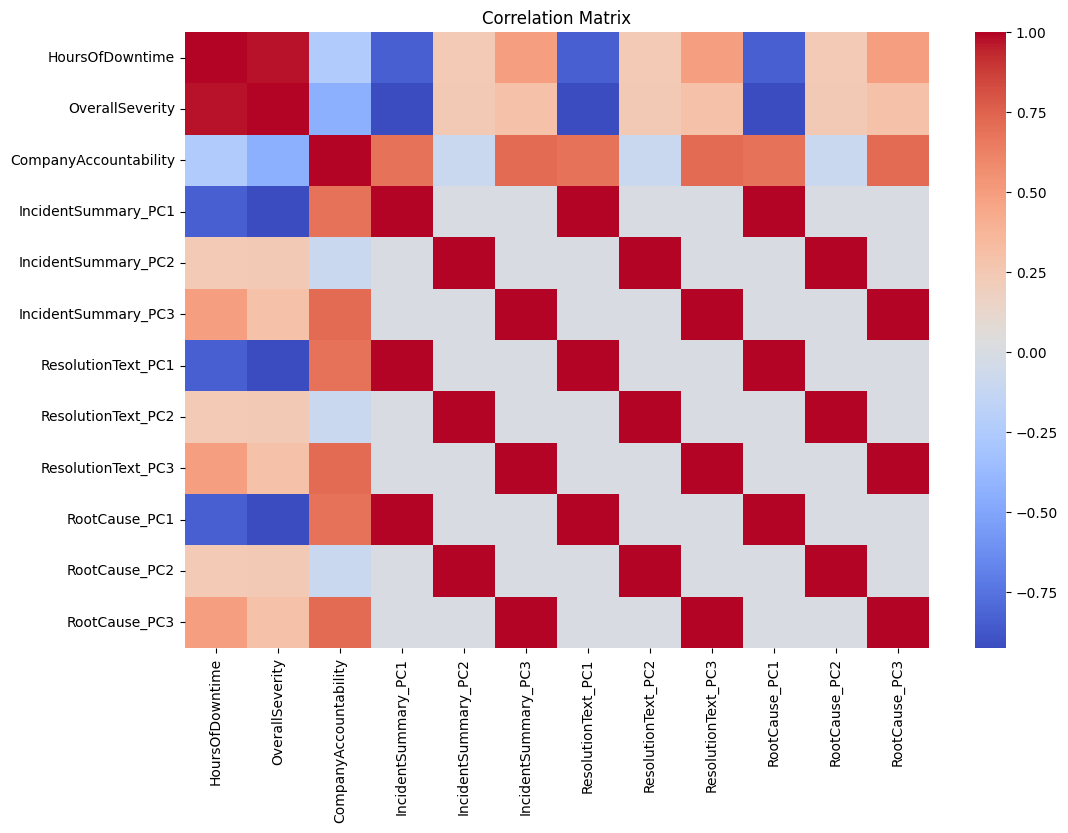

In [26]:
# Select only numeric columns for correlation matrix calculation
numeric_df_final = df_final.select_dtypes(include=[float, int])

# Calculate correlation matrix
correlation_matrix = numeric_df_final.corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')  # Set `annot=False` for large matrices
plt.title('Correlation Matrix')
plt.show()
